# Ibovespa Stock Picker
Author: Vinícius Assis Neves

### Summary:

This project aims to create a machine learning model that is capable of picking stocks that will overperform the market in the middle term (~1/2 years) - could potentially be used for the long term as well

Most of the stocks predicting ML models that exist currently are based on prices variations and usually do not have good results. A common approach is to use LSTM neural networks to predict the sequence of prices. As this is very subject to market fluctuations, this project presents a different way to handle the problem.

Instead of predicting the prices, the model created tries to predict the market cap of the company. Having a good accuracy on the model itself is not that important. In fact, as we can notice with experiments, a good but not excelent accuracy (like 80%) may bring the best results.


### Experiments Methodology:
This project's experiments are performed with the 2019 stocks data that would be available in the beggining of 2020, and tested with the 2020 and 2021 data. In a real use of this project, the test results would only be available in a couple of years time, this is why we are using 2019 data instead of 2022.

- After training the model to predict 2019's market cap, we get the predicted value for each stock (we don't differentiate train and test data here, as the test data will be the market caps for the next years)
- We define a threshold that represents how bigger than the actual 31/12/2019 market cap the predicted one needs to be for it to consider that the stock is very underpriced and it's likely a good pick.
- We simulate a porfolio with the same weight for every stock
- We get the stock price variation from the 2 studied periods (2019-2020 and 2019-2021) and apply to the simulated portfolio value
- We then have a initial and final price of the portfolio for both periods, therefore we are able to calculate the investment return rate, which would be what the picked portfolio would get in real life if the stocks had been bought in the very beggining of 2020.

### Data
- BPA - Balanço Patrimonial Ativo: Scrapped by the author's code from the official government website http://cvm.gov.br
- BPP - Balanço Patrimonial Passivo: Scrapped by the author's code from the official government website http://cvm.gov.br
- DRE - Demonstração de Resultado do Exercício: Scrapped by the author's code from the official government website http://cvm.gov.br
- market_caps.csv - Calculated based on values scrapped by the author's code from http://finance.yahoo.com
- cvm_to_ticker.csv - Tickers were scrapped from https://bvmf.bmfbovespa.com.br and liked with its CVM code

### Limitations
- Only 137 stocks have the requisites defined on this notebook to be used. The requisites are defined so we have standardized data without null/blank values. 137 stocks is a very small number, so although the results of the project seems promissing, it's no guarantee of real use results.
- Only the 2019-2020 and 2019-2021 periods were used here, so we can't state that we'd get results as good as the ones presented here for other periods.

### Further Ressearch
- To better evaluate this method, a bigger market should be used, for example the American stock market, which would give us far more stocks to use and an extended period of time.
- Important values on the companies standardized statements were carefully picked based on the Author's knowledge of statements analysis, but a better feature engineering could bee studied. One possibility is to use financial indicators instead of the raw values.
- This method could have its efficacy better understood by analyzing long period of times, and differend period lenghts, which would be possible by using a bigger stock market's data.

In [ ]:
%pip install scikit-learn
%pip install pandas
%pip install matplotlib

In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression


#### DRE (Demonstração de Resultado do Exercício - Income Statement of the Year)
Select from the ./demonstrativos.nosync/dre folder all the income statements scrapped and select only the ones that have valid values for the columns defined in the variable "essential_cols_dre"

In [2]:
import constants_ as consts

#DRE
dre_dir = consts.dre_dir

dres = dict()

codigos = [f for f in os.listdir(dre_dir) if os.path.isdir(os.path.join(dre_dir, f))]
for cod in codigos:
    # get only file inside cod
    file = [f for f in os.listdir(f"{dre_dir}{cod}/") if os.path.isfile(os.path.join(f"{dre_dir}{cod}/", f))][0]
    path = f"{dre_dir}{cod}/{file}"
    dres[int(cod)] = pd.read_csv(path)
    
essential_cols_dre = [
        ' Receita de Venda de Bens e/ou Serviços ', ' Resultado Bruto ', ' Custo dos Bens e/ou Serviços Vendidos ',
        ' Despesas/Receitas Operacionais ', ' Resultado Antes do Resultado Financeiro e dos Tributos ',
        ' Resultado Financeiro ', ' Resultado Antes dos Tributos sobre o Lucro ', ' Imposto de Renda e Contribuição Social sobre o Lucro ',
        ' Resultado Líquido das Operações Continuadas ', ' Lucro/Prejuízo do Período ',
    ]

valid_dres = dict()

for dre_cod in dres:
    dre = dres[dre_cod]
    # print(dre.head())
    if not ' Descrição ' in dre.columns: continue

    contas = dre[' Descrição ']

    # discards banks and other tickers that do not have ' Receita de Venda de Bens e/ou Serviços '
    if ' Receitas da Intermediação Financeira ' in contas.values: 
        continue
    if not ' Receita de Venda de Bens e/ou Serviços ' in contas.values:
        continue


    invalid = False
    for attr in essential_cols_dre:
        for c in ['01/01/2019 a 31/12/2019 ', '01/01/2020 a 31/12/2020 ', '01/01/2021 a 31/12/2021 ']:
            # remove the ones without any of the essential cols
            rec = dre[dre[' Descrição '] == attr]
            if not c in rec or len(rec[c].values) == 0:
                invalid = True
                break
            receita = rec[c].values[0].replace(' ', '')
            if receita == '': 
                invalid = True
                break
    if invalid: continue
    
    valid_dres[dre_cod] = dre

print(f'{len(valid_dres)} valid DREs')

387 valid DREs


#### BPA (Balanço Patrimonial Ativo - Balance Sheets Assets)
Select from the ./demonstrativos.nosync/bpa folder all the Balance Sheets Assets scrapped and select only the ones that have valid values for the columns defined in the variable "essential_cols_bpa"

In [3]:
import constants_ as c
bpa_dir = c.bpa_dir

bpas = dict()

codigos = [f for f in os.listdir(bpa_dir) if os.path.isdir(os.path.join(bpa_dir, f))]
for cod in codigos:
    file = [f for f in os.listdir(f"{bpa_dir}{cod}/") if os.path.isfile(os.path.join(f"{bpa_dir}{cod}/", f))][0]
    path = f"{bpa_dir}{cod}/{file}"
    bpas[int(cod)] = pd.read_csv(path)

essential_cols_bpa = [
        ' Ativo Total ', ' Ativo Circulante ', ' Ativo Não Circulante ', ' Caixa e Equivalentes de Caixa ', ' Contas a Receber ',
        ' Ativo Realizável a Longo Prazo ', ' Imobilizado ',
    ]

valid_bpas = dict()

for bpa_cod in bpas:
    bpa = bpas[bpa_cod]
    if not ' Descrição ' in bpa.columns: continue

    contas = bpa[' Descrição ']

    invalid = False
    for attr in essential_cols_bpa:
        for c in [' 31/12/2019 ', ' 31/12/2020 ', ' 31/12/2021 ']:
            # remove the ones without any of the essential cols
            rec = bpa[bpa[' Descrição '] == attr]
            if not c in rec or len(rec[c].values) == 0:
                invalid = True
                break
            receita = rec[c].values[0].replace(' ', '')
            if receita == '': 
                invalid = True
                break
    if invalid: continue
    
    valid_bpas[bpa_cod] = bpa

print(f'{len(valid_bpas)} valid bpas')

396 valid bpas


#### BPP (Balanço Patrimonial Passivo - Balance Sheet Liabilities)
Select from the ./demonstrativos.nosync/bpp folder all the Balance Sheets Liabilities statements scrapped and select only the ones that have valid values for the columns defined in the variable "essential_cols_bpp"

In [4]:
import constants_ as c
bpp_dir = c.bpp_dir

bpps = dict()

codigos = [f for f in os.listdir(bpp_dir) if os.path.isdir(os.path.join(bpp_dir, f))]
for cod in codigos:
    file = [f for f in os.listdir(f"{bpp_dir}{cod}/") if os.path.isfile(os.path.join(f"{bpp_dir}{cod}/", f))][0]
    path = f"{bpp_dir}{cod}/{file}"
    try:
        bpps[int(cod)] = pd.read_csv(path)
    except:
        continue

essential_cols_bpp = [
        ' Passivo Total ', ' Passivo Circulante ', ' Passivo Não Circulante ', ' Patrimônio Líquido ',
    ]

valid_bpps = dict()

for bpp_cod in bpps:
    bpp = bpps[bpp_cod]
    if not ' Descrição ' in bpp.columns: continue

    contas = bpp[' Descrição ']

    invalid = False
    for attr in essential_cols_bpp:
        for c in [' 31/12/2019 ', ' 31/12/2020 ', ' 31/12/2021 ']:
            # remove the ones without any of the essential cols
            rec = bpp[bpp[' Descrição '] == attr]
            if not c in rec or len(rec[c].values) == 0:
                invalid = True
                break
            receita = rec[c].values[0].replace(' ', '')
            if receita == '': 
                invalid = True
                break
    if invalid: continue
    
    valid_bpps[bpp_cod] = bpp

print(f'{len(valid_bpps)} valid bpps')

456 valid bpps


#### Map CVM code to market cap data

In [5]:
market_caps = pd.read_csv('market_caps.csv')
cvm_to_ticker = pd.read_csv('cvm_to_ticker.csv')

mc = dict()

for t in market_caps['Ticker']:
    cvm = cvm_to_ticker[cvm_to_ticker['Ticker'] == t]['CVM'].values[0]
    mc[cvm] = {
        'ticker': t,
        'market_cap': market_caps[market_caps['Ticker'] == t]
    }

valid_keys = mc.keys() & valid_bpas.keys() & valid_dres.keys() & valid_bpps.keys()
print(len(valid_keys))

137


#### Training Dataset
Combine the data from the 3 stataments (for the stocks that we have all the 3 available) and create a new dataset

Note: Only the 2019 data is used here. Using data from another year highly impact the results as the market cap of a company fluctuates as the market does. And every year has a completely different market scenario. Therefore, without years distinction, one year's data can't be used to predict another year's stocks market cap

In [6]:
dre_fields_col = []

for dre_cod in valid_keys:
    dre = valid_dres[dre_cod]
    bpa = valid_bpas[dre_cod]
    bpp = valid_bpps[dre_cod]

    
    for year in [2019]:
        dre_fields = dict()
        dre_fields['cod'] = dre_cod
        for e in essential_cols_dre:
            conta_row = dre[dre[' Descrição '] == e]
            e = e.replace(' ', '').replace('/', '').lower()
            dre_fields[e] = conta_row[f'01/01/{year} a 31/12/{year} '].values[0].replace(' ', '')
        for e in essential_cols_bpa:
            conta_row = bpa[bpa[' Descrição '] == e]
            e = e.replace(' ', '').replace('/', '').lower()
            dre_fields[e] = conta_row[f' 31/12/{year} '].values[0].replace(' ', '')
        for e in essential_cols_bpp:
            conta_row = bpp[bpp[' Descrição '] == e]
            e = e.replace(' ', '').replace('/', '').lower()
            dre_fields[e] = conta_row[f' 31/12/{year} '].values[0].replace(' ', '')
        dre_fields['mc'] = mc[dre_cod]['market_cap'][f'{year} MC'].values[0]
        dre_fields_col.append(dre_fields)


df = pd.DataFrame(dre_fields_col)
df

,cod,receitadevendadebenseouserviços,resultadobruto,custodosbenseouserviçosvendidos,despesasreceitasoperacionais,resultadoantesdoresultadofinanceiroedostributos,resultadofinanceiro,resultadoantesdostributossobreolucro,impostoderendaecontribuiçãosocialsobreolucro,resultadolíquidodasoperaçõescontinuadas,...,ativonãocirculante,caixaeequivalentesdecaixa,contasareceber,ativorealizávelalongoprazo,imobilizado,passivototal,passivocirculante,passivonãocirculante,patrimôniolíquido,mc
0,21008,139215,102756,-36459,14345,117101,-144231,-27130,-7182,-34312,...,1341996,197654,56155,362589,18127,1699421,232543,1462507,4371,1.890328e+08
1,19992,2282124,1472630,-809494,-1147426,325204,-1177,324027,-70111,253916,...,1531652,1538156,350995,328403,389432,3535927,705552,351966,2478409,1.284573e+10
2,21016,3565036,2044318,-1520718,-1144300,900018,-242090,657928,-11788,646140,...,4036808,12251,759622,693832,1732222,5512492,674870,1735270,3102352,1.386361e+10
3,24090,1353634,408008,-945626,-172910,235098,-31992,203106,-44702,158404,...,1109038,129469,282226,69557,497125,1625791,333746,595589,696456,3.361370e+09
4,1562,149310,77286,-72024,-69103,8183,1245,9428,-5234,4194,...,78720,5661,30886,43916,29673,190587,59368,23092,108127,1.003346e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,19445,5157224,2156327,-3000897,-1000939,1155388,-133084,1022304,-267930,754374,...,9686019,524146,1187496,2546938,1590921,11528815,1118034,3667068,6743713,6.729263e+09
133,22519,316225,109243,-206982,-235888,-126645,-5183,-131828,9174,-122654,...,283351,54109,154790,51918,38992,676091,163063,168543,344485,2.562034e+08
134,22012,439465,156972,-282493,-199960,-42988,-14056,-57044,12064,-44980,...,1069891,124910,116803,321974,576575,1375895,174232,94290,1107373,2.482665e+09
135,19453,3952889,1503882,-2449007,-708186,795696,-700072,95624,-280904,-185280,...,9215413,1856248,177757,775819,545424,11542453,4008319,7078783,455351,1.133862e+10


#### Simulation of stock picking

- predicted_market_cap: the predicted 2019 market caps generated by one ML algorithm
- y: the actual 2019 market cap for the stocks
- threshold_times: if the predicted value is bigger than the actual value times threshold_times, the stock is picked for the simulated porfolio

Experiment:
- Simulate a porfolio with the same weight for every stock
- Get the stock price variation from the 2 studied periods (2019-2020 and 2019-2021) and apply to the simulated portfolio value
- We then have a initial and final price of the portfolio for both periods, therefore we are able to calculate the investment return rate, which would be what the picked portfolio would get in real life if the stocks had been bought in the very beggining of 2020.

Printed values:
- Training score of the ML model (to predict 2019 stocks market cap)
- How many stocks have been picked with the threshold
- The simulated portfolio investment return over the 2 periods (range -100% to infinity)
- The percentage of the picked stocks that had positives results
- The results of each picked stocks individually for both periods

Graphs plotted:
- 2 graphs are plotted to visualize the return of the investment of each individual stocks.
- The goal of the graph is to show how each stock impacted the final result and to show the outliers (stocks that had unbelivable returns) so their result over the periods can be manually cheched.

In [7]:
def test_ml_portfolio(predicted_market_cap, y, threshold_times=10):

    bigger = 0
    selected_tickers = []
    for i in range(len(predicted_market_cap)):
        if predicted_market_cap[i] > y[i]*threshold_times:
            bigger += 1
            selected_tickers.append(mc[X.iloc[i]['cod']]['ticker'])
    print(f'{bigger} tickers have predicted market cap higher than {threshold_times} of the real one')
    print(f'Total of tickers: {len(predicted_market_cap)}')

    invested = len(selected_tickers)
    final_value_2020 = 0
    final_value_2021 = 0

    if invested < 3: 
        print('To few tickets selected, try a different random state or threshold times')
        return

    map_2021 = dict()
    map_2020 = dict()

    for ticker in selected_tickers:
        cod_cvm = cvm_to_ticker[cvm_to_ticker['Ticker'] == ticker]['CVM'].values[0]
        
        return_this_2021 = mc[cod_cvm]['market_cap']['2021 MC'].values[0] / mc[cod_cvm]['market_cap']['2019 MC'].values[0]
        return_this_2020 =  mc[cod_cvm]['market_cap']['2020 MC'].values[0] / mc[cod_cvm]['market_cap']['2019 MC'].values[0]
        final_value_2020 += (return_this_2020)
        final_value_2021 += (return_this_2021)

        map_2020[ticker] = (return_this_2020-1) * 100
        map_2021[ticker] = (return_this_2021-1) * 100

    return_2020 = (final_value_2020/invested - 1) * 100
    return_2021 = (final_value_2021/invested - 1) * 100
    print(f'Return 2020: {return_2020}%')
    print(f'Return 2021: {return_2021}%')

    def print_stats(map, until):

        positives = 0
        negatives = 0
        for ticker in map:
            val = map[ticker]
            if val > 0:
                positives += 1
            else:
                negatives += 1

        print(f'2019-{until}: {(positives/(positives+negatives))*100}% positives')

        fig, ax = plt.subplots(figsize=(25,1))
        ax.set_xlabel(f'Retorno de 31/12/2019 a 31/12/{until} (%)')
        ax.set_ylabel('')
        ax.set_xlim([-100, 500])
        ax.vlines(0,-1,1, colors='red')
        ax.tick_params(labelleft=False)    
        ax.scatter([map[x] for x in map], [0 for x in map], label=f'Return {until}')

    print()
    print_stats(map_2020, 2020)
    print_stats(map_2021, 2021)

    print()
    print(map_2020)
    print(map_2021)

#### X y split
y is the 2019 market cap

In [8]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

#### Linear Regression

Train Accuracy: 0.7856645881479715
13 tickers have predicted market cap higher than 34 of the real one
Total of tickers: 137
Return 2020: 304.2468961668778%
Return 2021: 158.55043327406406%

2019-2020: 69.23076923076923% positives
2019-2021: 69.23076923076923% positives

{'BALM3': 86.74472154183917, 'EPAR3': 85.45752604099712, 'CALI3': 0.0, 'CRDE3': -4.625469467173115, 'BMKS3': -5.304594917789151, 'MWET3': 731.1428615025111, 'ESTR3': 0.0, 'NUTR3': 391.11111111111114, 'OSXB3': 520.1835108543157, 'TXRX3': 1767.5286640105376, 'MNPR3': 18.64406587885088, 'TEKA3': 349.7499942779541, 'BDLL3': 14.577259336256954}
{'BALM3': 43.22734534562829, 'EPAR3': 114.37908710615163, 'CALI3': 0.0, 'CRDE3': -42.844144418015695, 'BMKS3': -7.365895985014537, 'MWET3': 221.42857142857136, 'ESTR3': 100.0, 'NUTR3': 462.2222222222222, 'OSXB3': 108.56269759760107, 'TXRX3': 877.011488897984, 'MNPR3': 8.30508073216647, 'TEKA3': 226.25000476837158, 'BDLL3': -50.02082513283321}


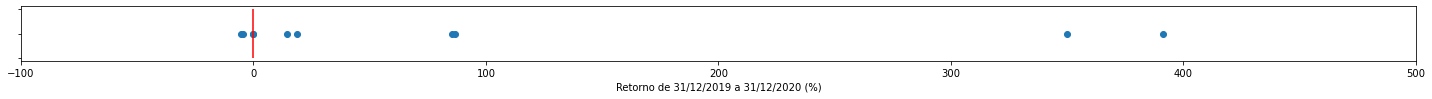

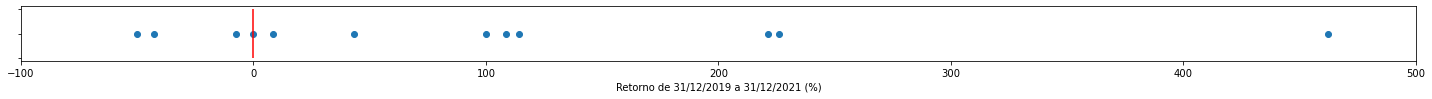

In [9]:
reg = LinearRegression().fit(X, y)
print(f'Train Accuracy: {reg.score(X, y)}')

test_ml_portfolio(reg.predict(X), y, threshold_times=34)

#### Multilayer perceptron neural network

Train Accuracy: 0.8581936211085144
12 tickers have predicted market cap higher than 13 of the real one
Total of tickers: 137
Return 2020: 324.1004513323116%
Return 2021: 195.72772127085915%

2019-2020: 75.0% positives
2019-2021: 83.33333333333334% positives

{'MTSA3': 58.64530962200109, 'HAGA3': -30.817610785916607, 'EPAR3': 85.45752604099712, 'FRIO3': 3.27868852459019, 'MWET3': 731.1428615025111, 'ESTR3': 0.0, 'NUTR3': 391.11111111111114, 'OSXB3': 520.1835108543157, 'TXRX3': 1767.5286640105376, 'PFRM3': -5.718705049213302, 'MNPR3': 18.64406587885088, 'TEKA3': 349.7499942779541}
{'MTSA3': 206.05053114465443, 'HAGA3': 45.49266425515685, 'EPAR3': 114.37908710615163, 'FRIO3': -17.065573520347698, 'MWET3': 221.42857142857136, 'ESTR3': 100.0, 'NUTR3': 462.2222222222222, 'OSXB3': 108.56269759760107, 'TXRX3': 877.011488897984, 'PFRM3': -3.904119382221971, 'MNPR3': 8.30508073216647, 'TEKA3': 226.25000476837158}


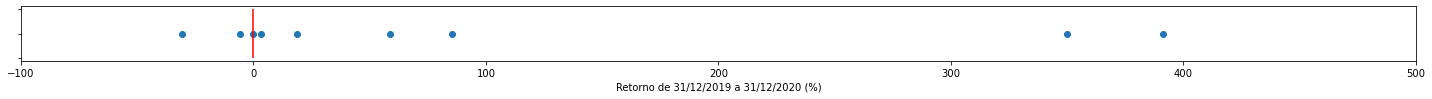

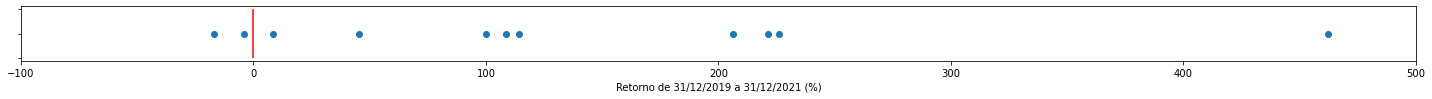

In [10]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=7, max_iter=10000000000000000)
clf.fit(X, y)
print(f'Train Accuracy: {clf.score(X, y)}')
test_ml_portfolio(clf.predict(X), y, threshold_times=13)


#### Results
##### Linear Regression: 
Training score of the market cap prediction model is ~78%. With a threshold value of 34, 13 stocks were picked. A simulated portfolio with these stocks bought in the very beggining of 2020 would get an investment return of 300% by the end of 2020 and 158% by the end of 2021.

-----

##### Multilayer-Perceptron Neural Network:
Training score of the market cap prediction model is ~85%. With a threshold value of 13, 12 stocks were picked. A simulated portfolio with these stocks bought in the very beggining of 2020 would get an investment return of 324% by the end of 2020 and 195% by the end of 2021.

Varying the random_state value changes drastically the results as the dataset is too small, but overral, even when the accuracy is not good, the return for the simulated portfolio is positive and much higher than the actual market return for that period.

